# April 6-8, 2022: Schaefer parcellation (300), plot fMRI time series of approach and retreat segments

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations
from operator import add

# explanation tools
# import shap

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/mar22"

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *
from nb.apr22.ROIwise_appr_retr_timeseries_plots_helper import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
# shap.initjs()

2022-04-08 14:34:15.815042: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-08 14:34:17.508788: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-08 14:34:17.558286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-04-08 14:34:17.558473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-04-08 14:34:17.558500: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

In [2]:
# roi names
masker_file = (f"/home/joyneelm/approach-retreat/data"
               f"/Schaefer_roi300_roi_names.txt")
masker_labels = pd.read_csv(masker_file, header=None, names=['roi_name']).iloc[0::2].values

# networks
vis = np.concatenate((np.arange(24),150+np.arange(24)))
somot = np.concatenate((np.arange(24,53),150+np.arange(24,53)))
dorsattn = np.concatenate((np.arange(53,69),150+np.arange(53,69)))
ventattn = np.concatenate((np.arange(69,85),150+np.arange(69,85)))
limbic = np.concatenate((np.arange(85,95),150+np.arange(85,95)))
cont = np.concatenate((np.arange(95,112),150+np.arange(95,112)))
default = np.concatenate((np.arange(112,150),150+np.arange(112,150)))

masks_list = {
    'no lesion':None,
    'visual':vis,
    'somato-motor':somot,
    'dorsal attention':dorsattn,
    'ventral attention':ventattn,
    'limbic':limbic, 
    'executive control':cont, 
    'default mode':default, 
}

### hemolag = 0

In [ ]:
#HIDE
hemo_lag = 0
raw_data_file = (f"/home/joyneelm/approach-retreat/near_miss_analysis/classification_data"
                 f"/Schaefer2018_roi300_net17_122subjs_full_segments_withshock_hemodynamic_lag{hemo_lag}.pkl")
with open(raw_data_file, 'rb') as f:
    data = pickle.load(f)

model_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}"
model = tf.keras.models.load_model(model_file)

class ARGS(): pass
args = ARGS()

args.SEED = 74

# data
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[args.num_train:]

(X_train, y_train, 
len_train, 
pos_train, idx_train) = get_data_samples(data, train_list)
y_preds_train = tf.keras.layers.Softmax()(model.predict(X_train)).numpy()
ts_train = get_appr_retr_segment_data(X_train, y_train, y_preds_train)

(X_test, y_test, 
len_test, 
pos_test, idx_test) = get_data_samples(data, test_list)
y_preds_test = tf.keras.layers.Softmax()(model.predict(X_test)).numpy()
ts_test = get_appr_retr_segment_data(X_test, y_test, y_preds_test)

tf.random.set_seed(args.SEED)

48


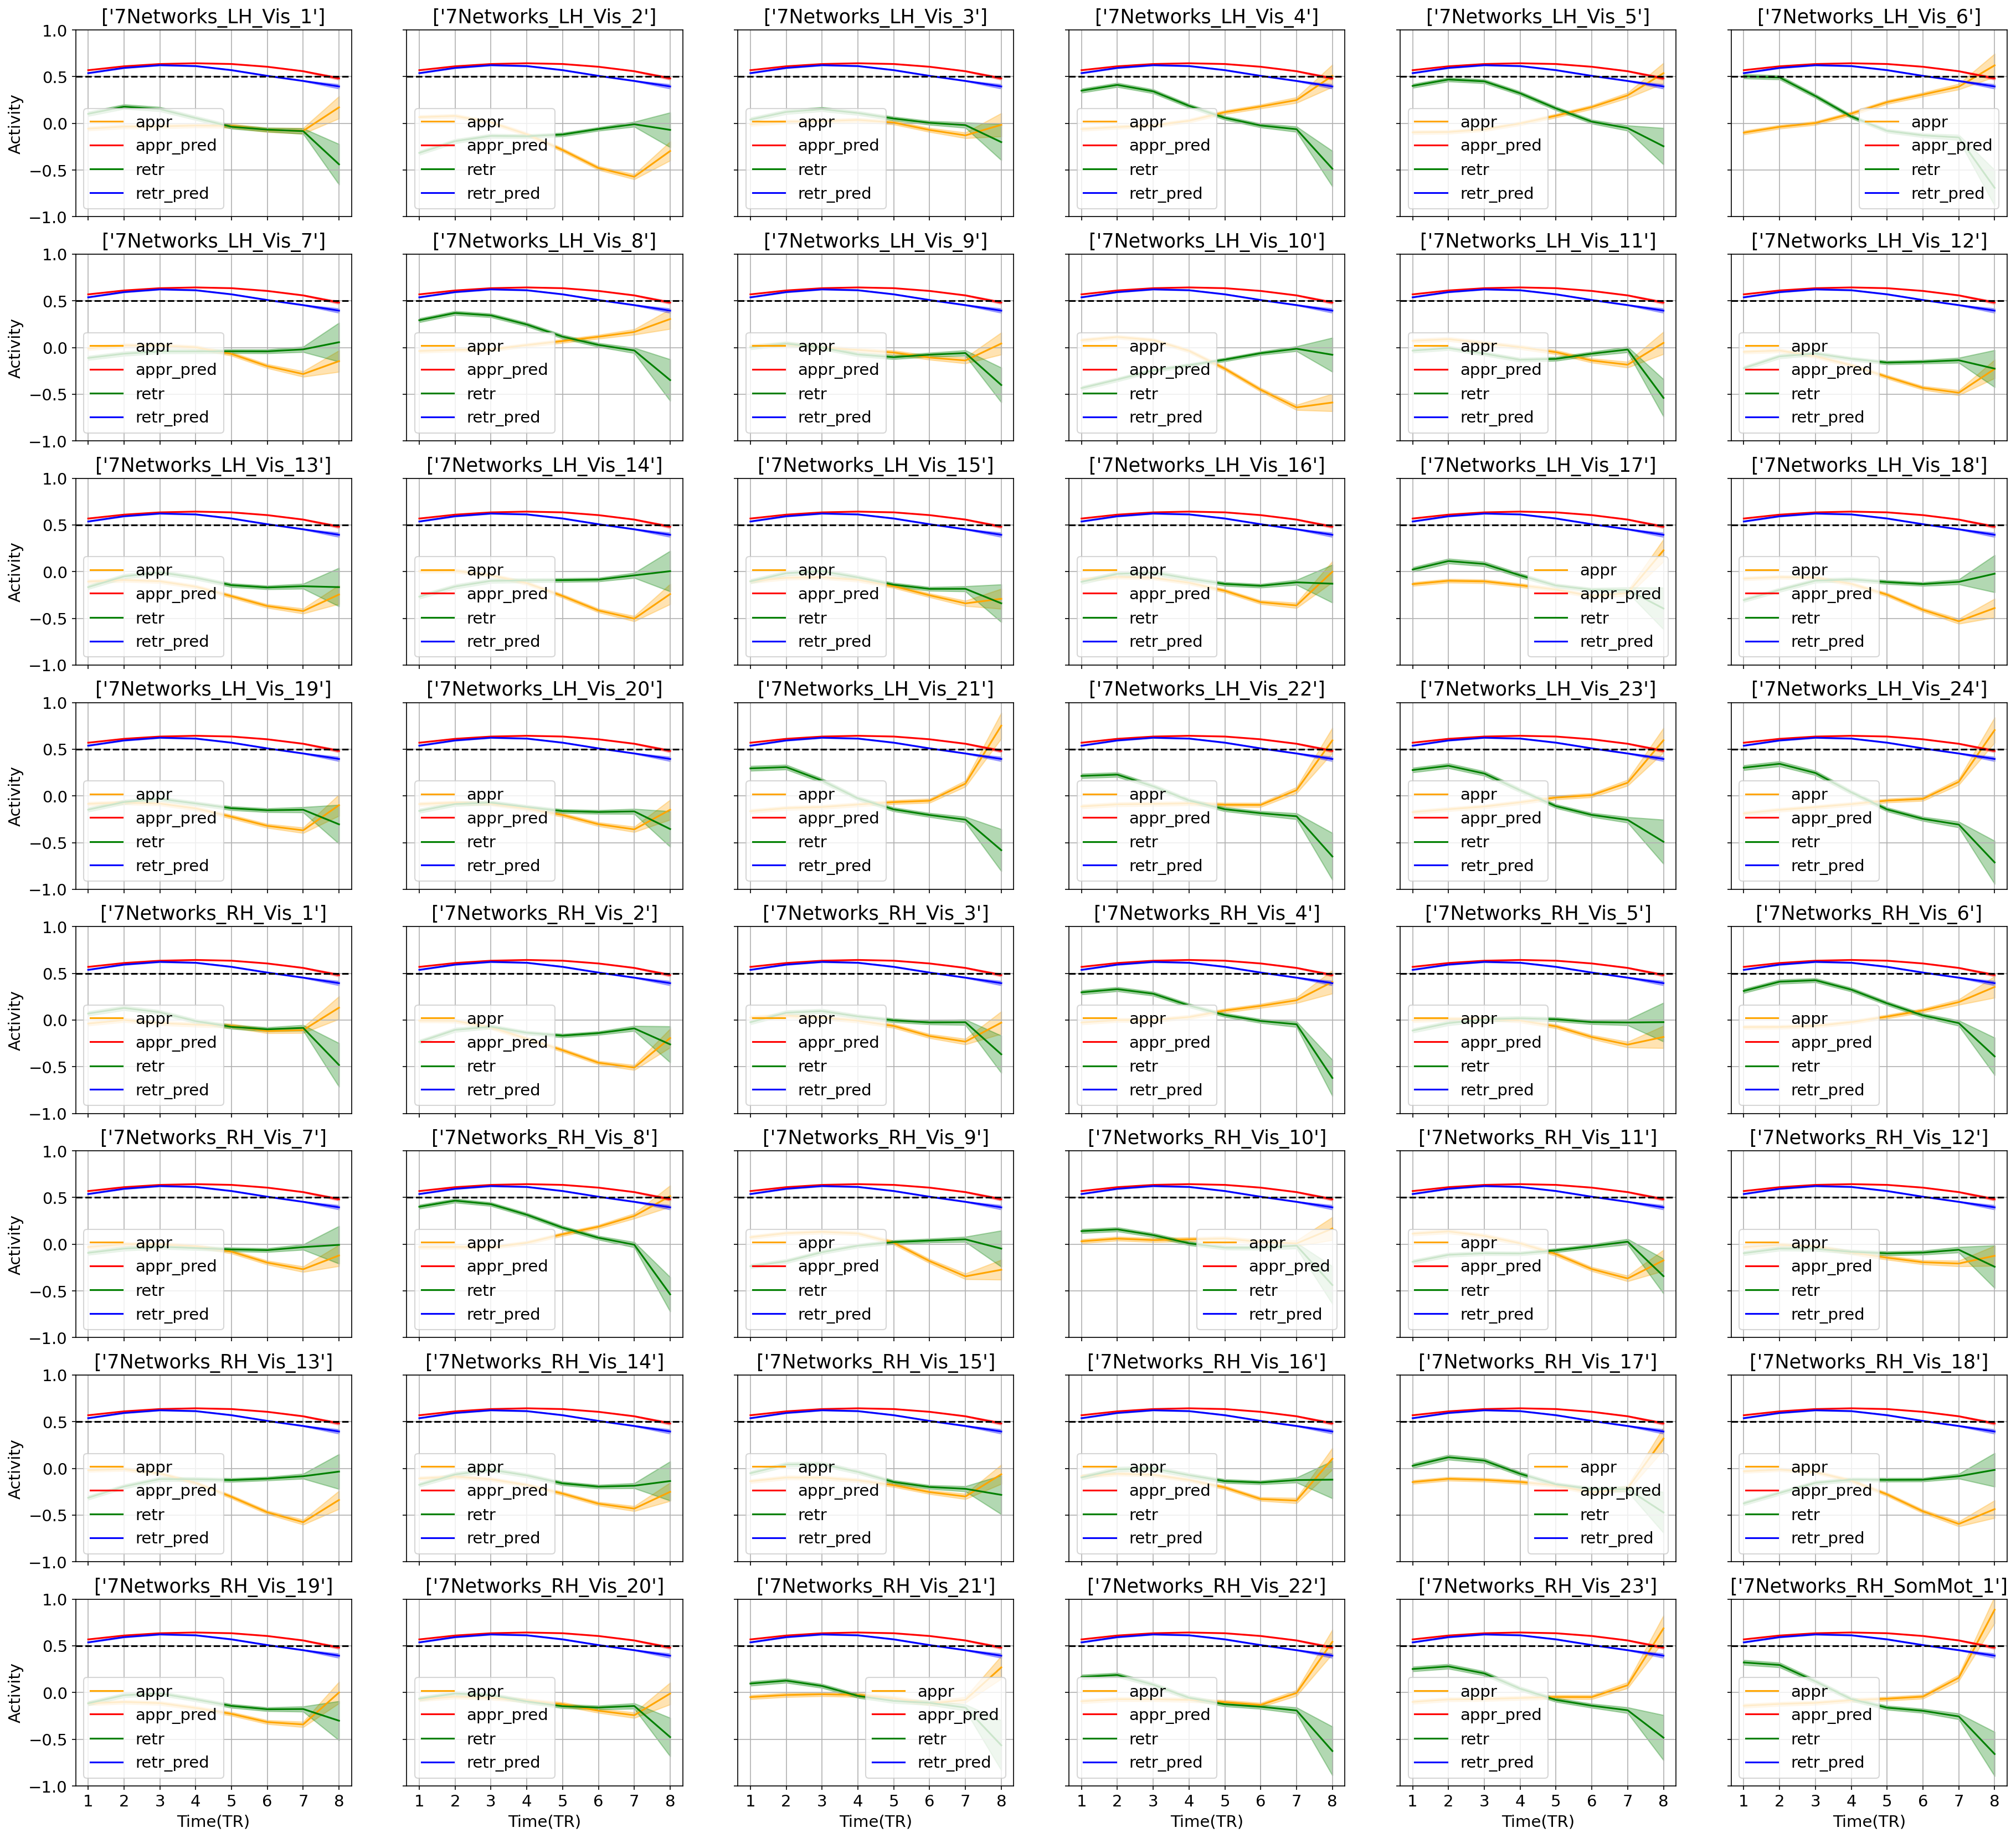

In [7]:
nw = vis
print(len(nw))
nrows, ncols = 8, 6 # 48 = 8 * 6
figsize = (5*ncols, 3.5*nrows)
plot_roi_ts(
    ts_train, 
    nw, masker_labels, nrows, ncols, figsize)

### hemolag = 2

In [5]:
#HIDE
hemo_lag = 2
raw_data_file = (f"/home/joyneelm/approach-retreat/near_miss_analysis/classification_data"
                 f"/Schaefer2018_roi300_net17_122subjs_full_segments_withshock_hemodynamic_lag{hemo_lag}.pkl")
with open(raw_data_file, 'rb') as f:
    data = pickle.load(f)

model_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}"
model = tf.keras.models.load_model(model_file)

class ARGS(): pass
args = ARGS()

args.SEED = 74

# data
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[args.num_train:]

(X_train, y_train, 
len_train, 
pos_train, idx_train) = get_data_samples(data, train_list)
y_preds_train = tf.keras.layers.Softmax()(model.predict(X_train)).numpy()
ts_train = get_appr_retr_segment_data(X_train, y_train, y_preds_train)

(X_test, y_test, 
len_test, 
pos_test, idx_test) = get_data_samples(data, test_list)
y_preds_test = tf.keras.layers.Softmax()(model.predict(X_test)).numpy()
ts_test = get_appr_retr_segment_data(X_test, y_test, y_preds_test)

tf.random.set_seed(args.SEED)

48


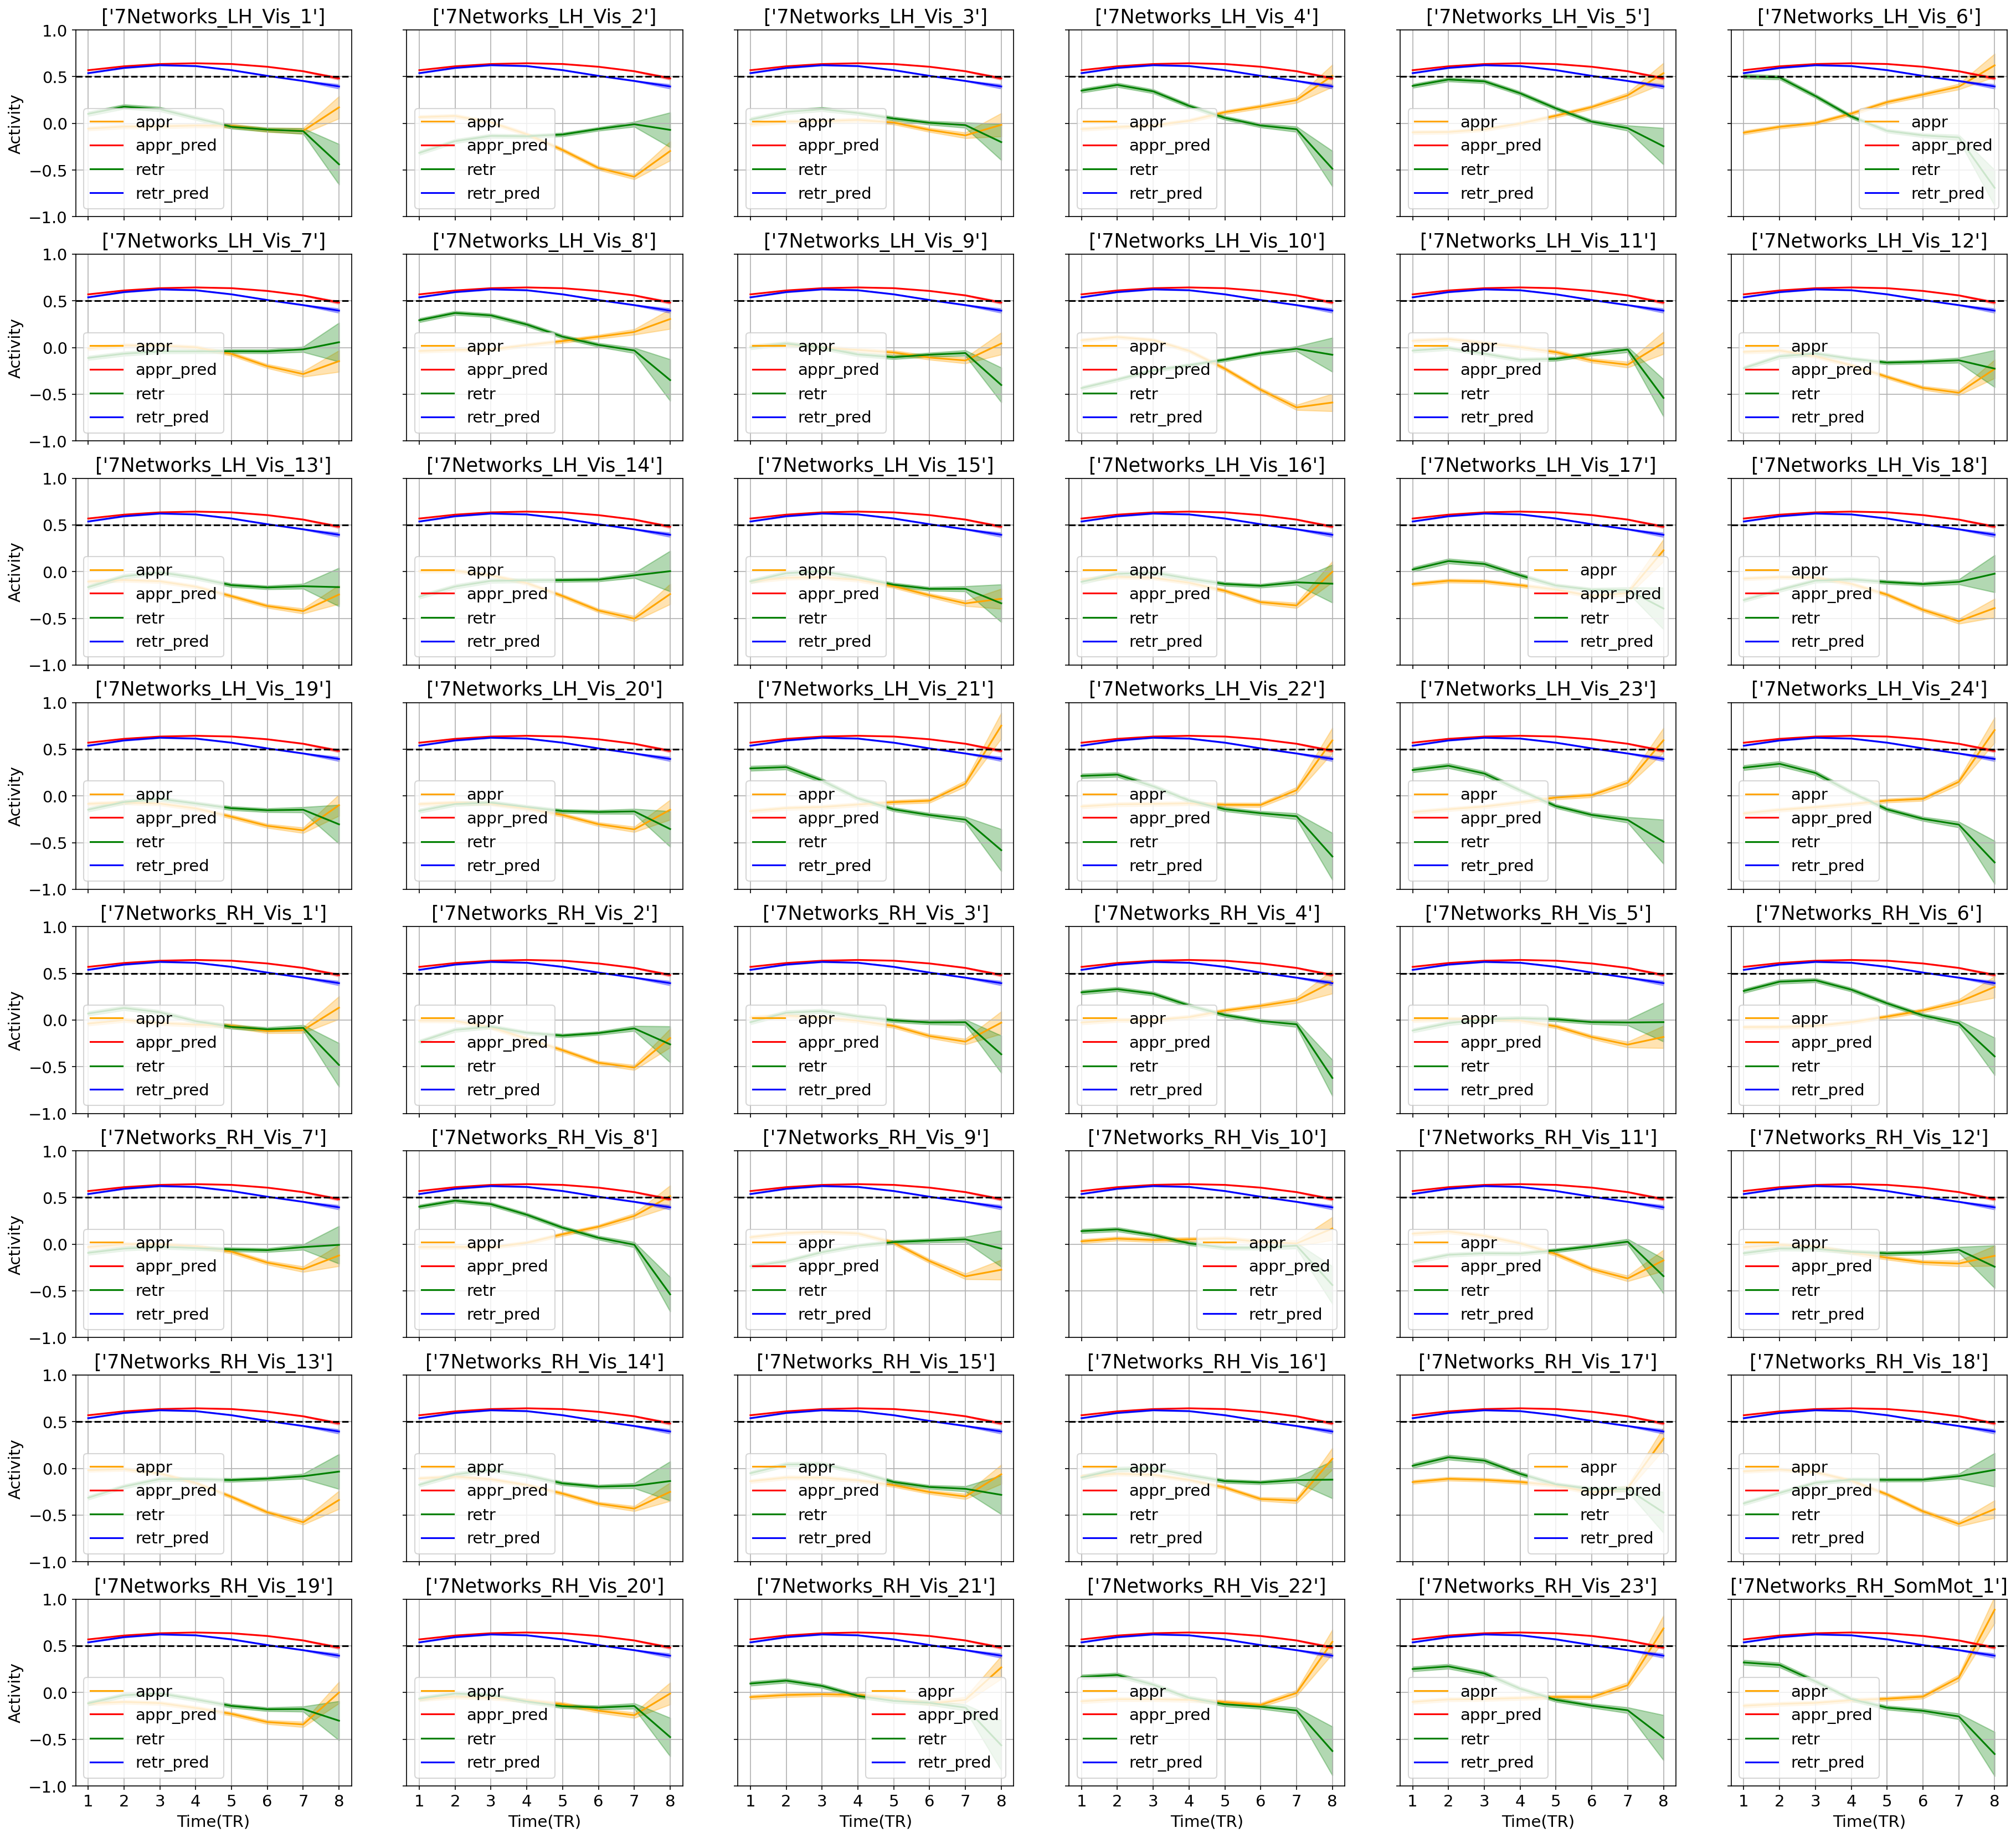

In [6]:
w = vis
print(len(nw))
nrows, ncols = 8, 6 # 48 = 8 * 6
figsize = (5*ncols, 3.5*nrows)
plot_roi_ts(
    ts_train, 
    nw, masker_labels, nrows, ncols, figsize)

### hemo lag = 6

In [8]:
#HIDE
hemo_lag = 6
raw_data_file = (f"/home/joyneelm/approach-retreat/near_miss_analysis/classification_data"
                 f"/Schaefer2018_roi300_net17_122subjs_full_segments_withshock_hemodynamic_lag{hemo_lag}.pkl")
with open(raw_data_file, 'rb') as f:
    data = pickle.load(f)

model_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}"
model = tf.keras.models.load_model(model_file)

class ARGS(): pass
args = ARGS()

args.SEED = 74

# data
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[args.num_train:]

(X_train, y_train, 
len_train, 
pos_train, idx_train) = get_data_samples(data, train_list)
y_preds_train = tf.keras.layers.Softmax()(model.predict(X_train)).numpy()
ts_train = get_appr_retr_segment_data(X_train, y_train, y_preds_train)

(X_test, y_test, 
len_test, 
pos_test, idx_test) = get_data_samples(data, test_list)
y_preds_test = tf.keras.layers.Softmax()(model.predict(X_test)).numpy()
ts_test = get_appr_retr_segment_data(X_test, y_test, y_preds_test)

tf.random.set_seed(args.SEED)

48


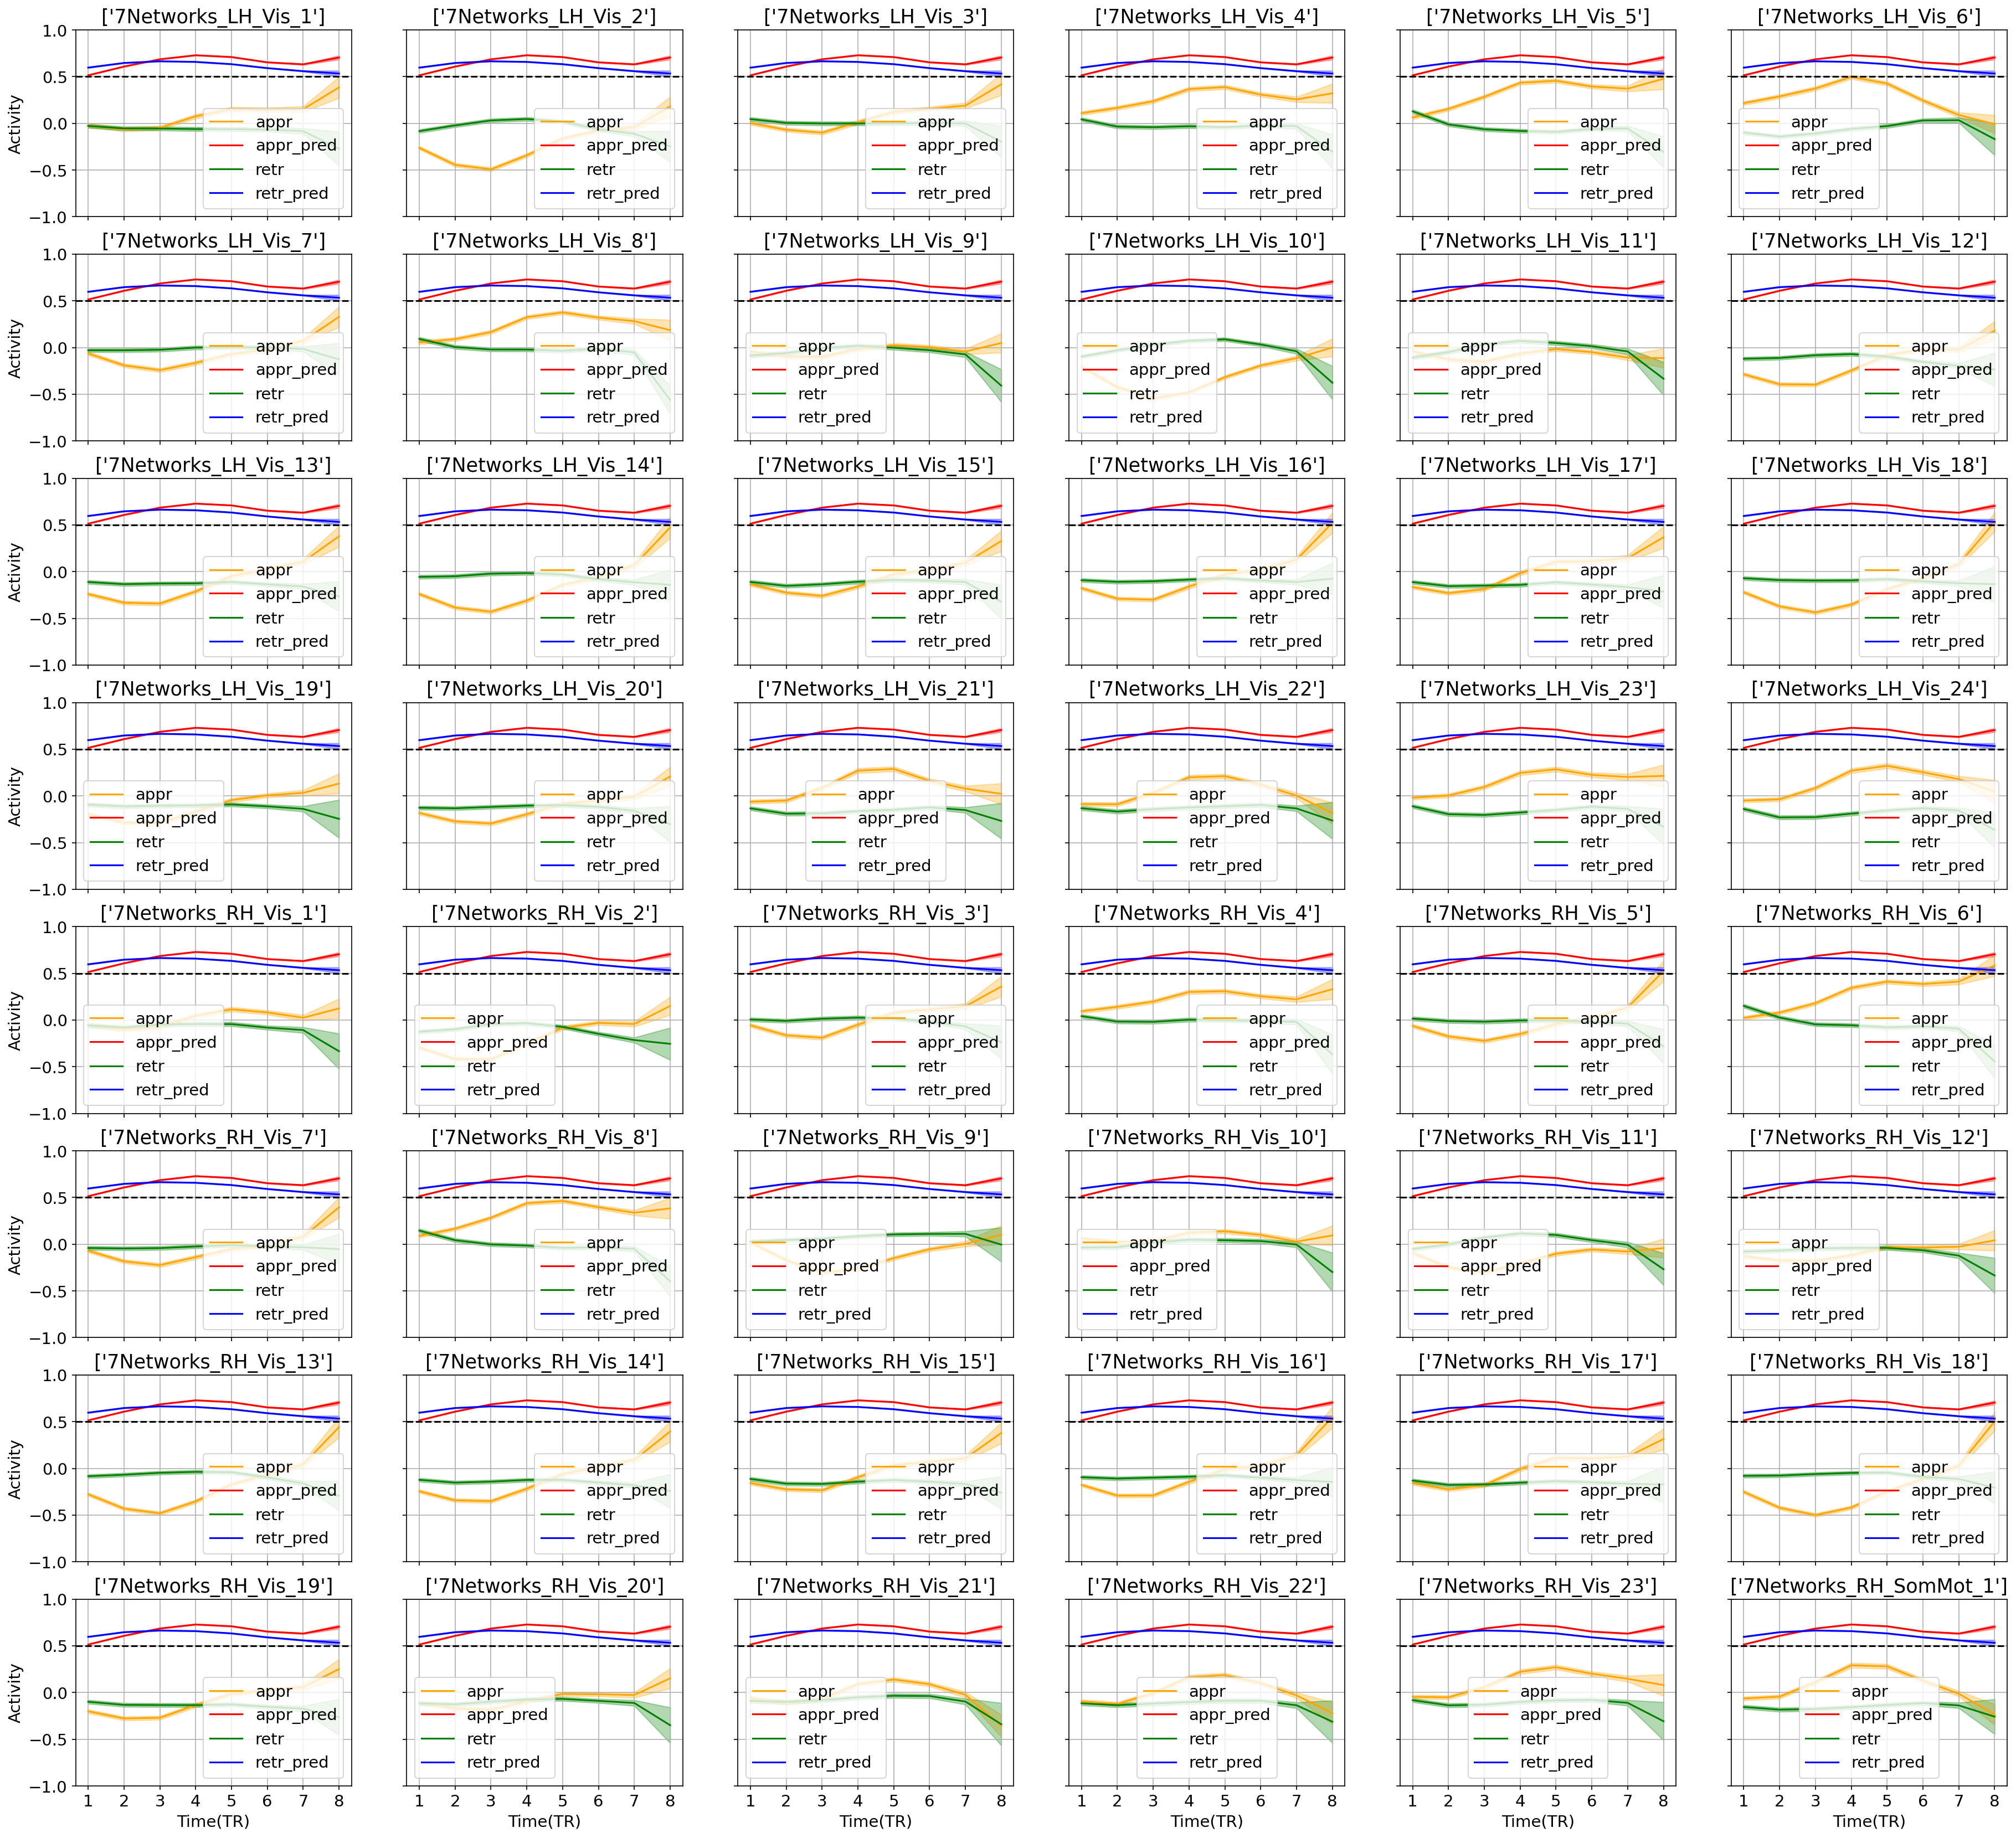

In [9]:
w = vis
print(len(nw))
nrows, ncols = 8, 6 # 48 = 8 * 6
figsize = (5*ncols, 3.5*nrows)
plot_roi_ts(
    ts_train, 
    nw, masker_labels, nrows, ncols, figsize)